In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET 5 : Catégorisation automatiquement des questions

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [MISSION 1: RECUPERATION ET TRAITEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
### [M1-1 : Récuperation des données](#6)<a class="anchor" id="sommaire"></a>
### [M1-2 : Traitement sur les données textes ](#7)<a class="anchor" id="sommaire"></a>
## [MISSION 2: EXPLORATION DES DONNEES](#9)<a class="anchor" id="sommaire"></a>
### [M2-1 : Mis en évidence et analyses des points intéressants  ](#10)<a class="anchor" id="sommaire"></a>
### [M2-2 : Sauvegarde des données  ](#11)<a class="anchor" id="sommaire"></a>



--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

Stack Overflow est un site de questions-réponses liées au développement informatique.
Les tags nous permettent de retrouver facilement la réponse à une question posée, pourtant ce n'est pas évident de trouver des tags associés à notre question.
Donc il était intéressant de développer un application qui suggererait automatiquement plusieurs tags pertinents à partir d'une question posée. 

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Stack Overflow propose un outil d’export de données en ligne sur - "stackexchange explorer" :
On retrouve 29 tables au total, mais pour notre besoin, la table 'Posts' suffira parce qu'elle contient la liste des questions posées avec les tags associés, le nombre de réponse, la note de pertinence associée à la question,...

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
import os
import re
import warnings
from time import time
from utils.functions import custom_tokenize, print_top_words
from utils.functions import predictTag, vectorizeInputTest
from utils.functions import remove_stopword, cleanText, pattern_searcher
from nltk.stem import WordNetLemmatizer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score

In [4]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## [MISSION 1: RECUPERATION ET TRAITEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

### [M1-1 : Récuperation des données](#sommaire)<a class="anchor" id="6"></a>

Les données proviennent de l'outil d'export des données de stackoverflow avec la requette suivante :


SELECT pst.Id, pst.Body,pst.Title,pst.Tags,pst.Score, pst.FavoriteCount,pst.AnswerCount

FROM posts pst 

WHERE pst.FavoriteCount > 50
AND pst.Score > 100
AND pst.Body is not null 
AND pst.Tags is not null
AND pst.Title is not null
AND pst.AnswerCount > 0

ORDER BY Id ASC


Puis stocker dans un fichier csv 'data/dataStackOverflow.csv' pour être utilisé 

In [5]:
df_prod = pd.read_csv('data/dataStackOverflow.csv', sep=',', engine='python')
df_test = pd.read_csv('data/dataStackOverflow_demo.csv',
                      sep=',', engine='python')
df = df_test.copy()
df.drop(['Score', 'FavoriteCount', 'AnswerCount'], axis=1, inplace=True)
print('dataframe : ', df.shape)

dataframe :  (2115, 4)


### [M1-2 : Traitement sur les données textes ](#sommaire)<a class="anchor" id="7"></a>

In [6]:
# Pour connaitre un peu plus notre table,
# nous allons regarder les champs qui le composent.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      2115 non-null   int64 
 1   Body    2115 non-null   object
 2   Title   2115 non-null   object
 3   Tags    2115 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.2+ KB


#### Extraction des données importantes :

- extraire le texte dans le body et title et concatener title et body

In [7]:
df['Body'] = df['Body'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
df['Title'] = df['Title'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())
df['BodyTitle'] = df['Title'].str.lower() + ' ' + df['Body'].str.lower()
df.drop(['Body', 'Title'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         2115 non-null   int64 
 1   Tags       2115 non-null   object
 2   BodyTitle  2115 non-null   object
dtypes: int64(1), object(2)
memory usage: 49.7+ KB


#### Pretraitement des données : 

- retirer les chiffres, la ponctuation, les caractères spéciaux et les stopwords
- conserver que le sens des mots utilisés en gardant infinitif, le singulier grace à lemmatizer

In [8]:
data = cleanText(df)
data.drop(['tokens', 'tokensStopWord'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            2115 non-null   int64 
 1   Tags          2115 non-null   object
 2   BodyTitle     2115 non-null   object
 3   words_tokens  2115 non-null   object
dtypes: int64(1), object(3)
memory usage: 66.2+ KB


On ne fait plus de stemming(racinisation) car :
- nous faisons dejà de Lemmatization(lemmatisation) et la bibliothèque nltk nous permet de le faire en Anglais pas comme le cas des textes en francais
- Les tags qu'on doit rechercher dans ces mots sont aussi en generale des mots techniques(ex java, javascript, C#) donc pas de mots derivés  

### [M2-1 : Mis en évidence et analyses des points intéressants :](#sommaire)<a class="anchor" id="10"></a>

### Fréquence des mots :

In [9]:
frequence_mots = {}


def count_frequence_words(word):
    for w in word:
        if w in list(frequence_mots.keys()):
            frequence_mots[w] += 1
        else:
            frequence_mots[w] = 1


print("Calcul de fréquence de chaque mot dans le corpus ...")
t0 = time()
data.words_tokens.apply(count_frequence_words)
print("fait en %0.3fs." % (time() - t0))

Calcul de fréquence de chaque mot dans le corpus ...
fait en 12.425s.


### Representations graphiques :

In [10]:
print('Nombre des mots : ', len(frequence_mots))

Nombre des mots :  10704


Donc nous avons 70 204 mots gardés sur les 19 757 questions dans notre jeu des données, 

voyons leur frequence d'utilisations : Par souci des visibilité, nous ne répresenterons que les 100 premiers sur nos graphes 

In [11]:
# Ne representer que les top 100
frequence_top100 = dict(sorted(frequence_mots.items(),
                               key=lambda x: x[1], reverse=True)[:100])
frequence_top1000 = dict(sorted(frequence_mots.items(),
                                key=lambda x: x[1], reverse=True)[:1000])

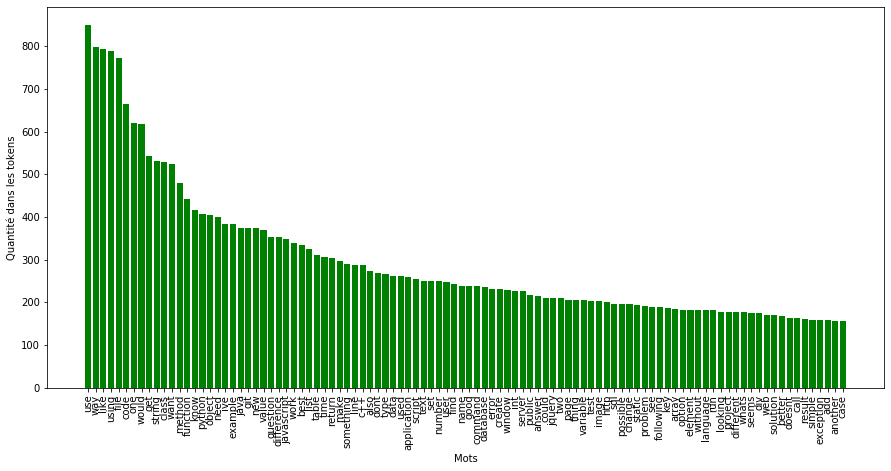

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(list(frequence_top100.keys()),
        frequence_top100.values(), color='g')
plt.xlabel('Mots')
plt.ylabel('Quantité dans les tokens')
plt.xticks(rotation=90)
plt.show()

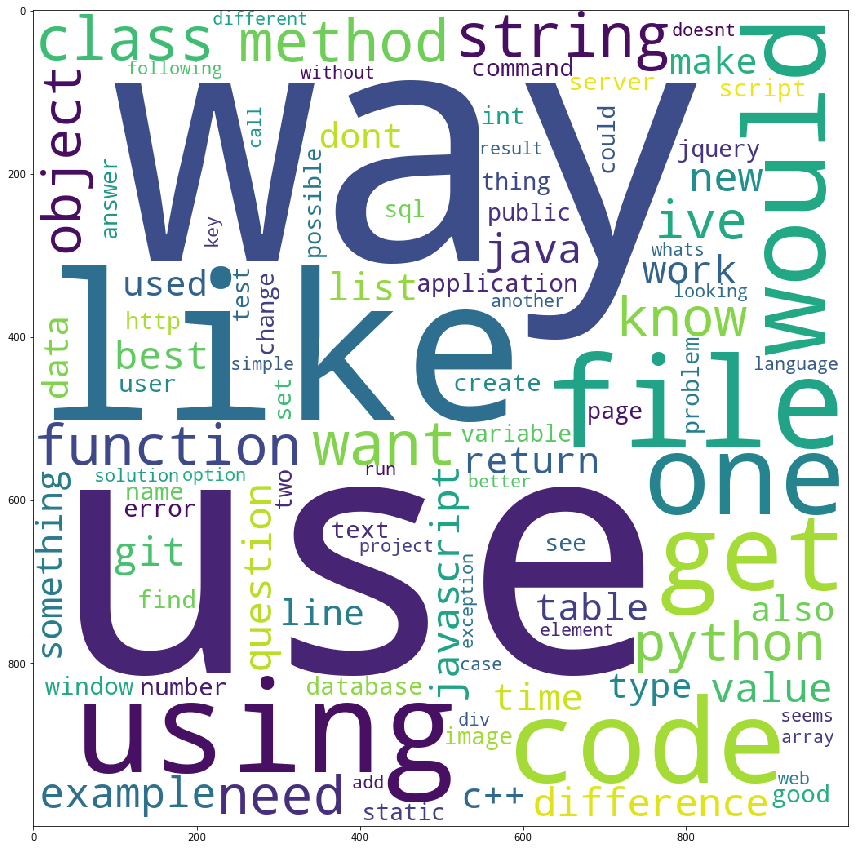

In [13]:
wc_word = WordCloud(background_color="white", width=1000, height=1000,
                    max_words=100, relative_scaling=0.5,
                    normalize_plurals=False).generate_from_frequencies(
    frequence_mots)
fig, ax = plt.subplots(figsize=(20, 15))
plt.imshow(wc_word)

### Fréquence des tags :

In [14]:
frequence_tags = {}


def count_frequence_tags(tags):
    for tag in tags:
        if tag in list(frequence_tags.keys()):
            frequence_tags[tag] += 1
        else:
            frequence_tags[tag] = 1


# tokenisé les tags :
data['tagtokens'] = data.Tags.apply(custom_tokenize)
data['tags_tokens'] = data.tagtokens.apply(remove_stopword)

print("Calcul de fréquence de chaque tag dans les tags ...")
t0 = time()
data.tags_tokens.apply(count_frequence_tags)
print("fait en %0.3fs." % (time() - t0))

Calcul de fréquence de chaque tag dans les tags ...
fait en 0.130s.


#### Representations graphiques

In [15]:
print('Nombre des tags : ', len(frequence_tags))

Nombre des tags :  1763


Donc nous avons 6 795 tags sur les 19 759 questions dans notre jeu des données, 

voyons leur frequence d'utilisations : Par souci des visibilité, nous ne répresenterons que les 100 premiers tags sur nos graphes

In [16]:
# Ne representer que les top 100 des tags
frequence_tag_top100 = dict(sorted(frequence_tags.items(),
                                   key=lambda x: x[1], reverse=True)[:100])

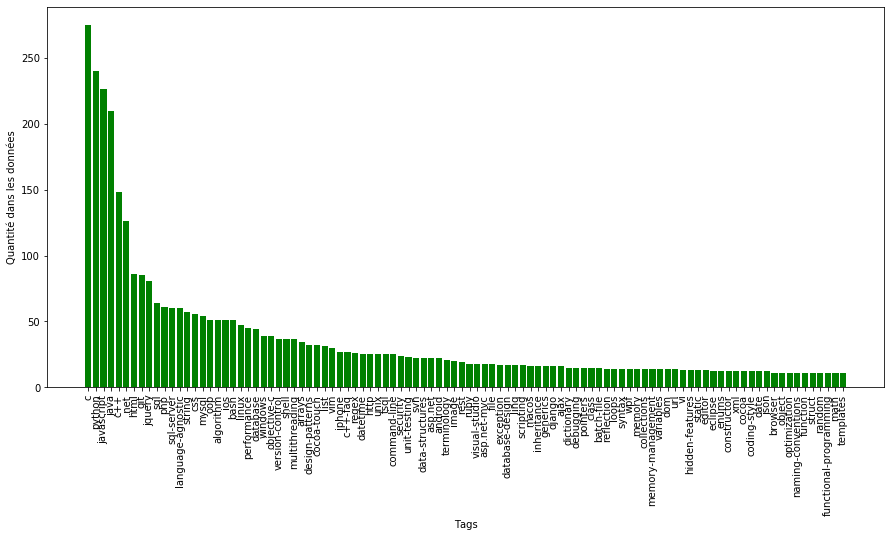

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(list(frequence_tag_top100.keys()),
        frequence_tag_top100.values(), color='g')
plt.xlabel('Tags')
plt.ylabel('Quantité dans les données')
plt.xticks(rotation=90)
plt.show()

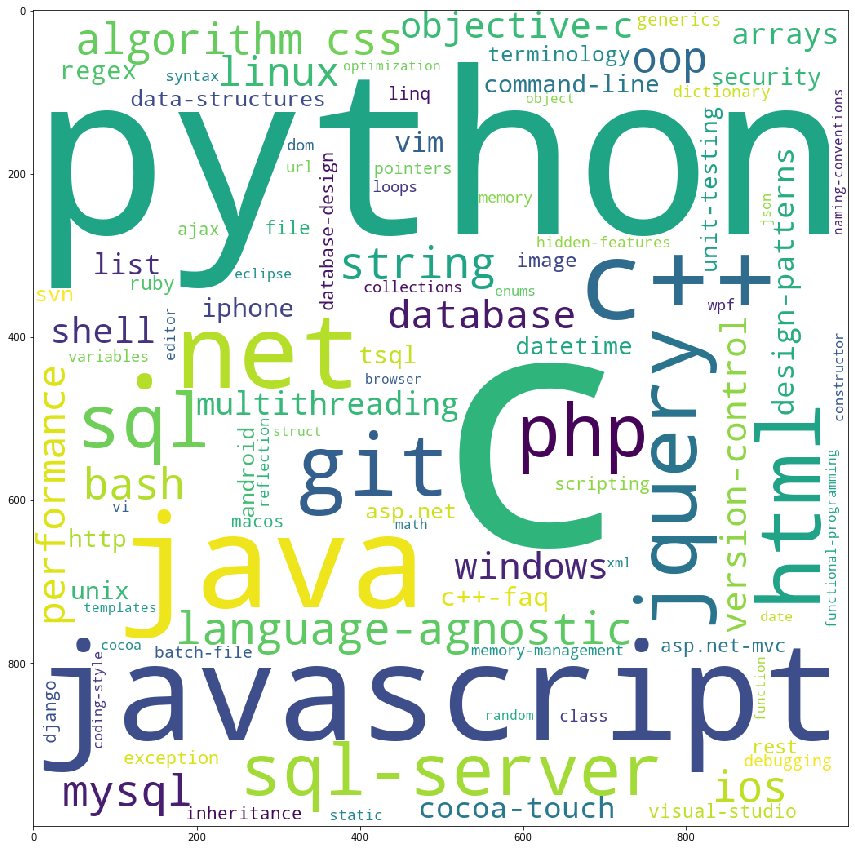

In [18]:
wc_tags = WordCloud(background_color="white", width=1000, height=1000,
                    max_words=100, relative_scaling=0.5,
                    normalize_plurals=False).generate_from_frequencies(
    frequence_tags)
fig, ax = plt.subplots(figsize=(20, 15))
plt.imshow(wc_tags)

In [19]:
# Ne garder que les lignes qui contiennent les top 100 des tags :
import re
top100tags = list(frequence_tag_top100.keys())
pattern = '|'.join(top100tags)
patternreplace = pattern.replace('++', '#')

In [20]:
data['words_tokens_concate'] = ['|'.join(map(str,
                                             l)) for l in data['words_tokens']]
data['keeprow'] = data['words_tokens_concate'].apply(
    lambda x: pattern_searcher(search_str=x,
                               search_list=patternreplace))
data.shape

(2115, 8)

- Ne garder que les lignes qui contiennent des tags top 100

In [21]:
data_copy = data[(data['keeprow'] > 0)]
data_copy.shape

(2104, 8)

In [22]:
tags_words_tokens = data_copy[['Id', 'BodyTitle',
                               'words_tokens', 'tags_tokens']]

### [M2-2 : Sauvegarde des données  :](#sommaire)<a class="anchor" id="11"></a>

Pour éviter de calculer à chaque fois les données, nous allons les stocker dans des fichiers texte :

- data/tags_words_tokens.csv : contient les données de base
- data/Backup/top1000_words.csv : contient les données de top 1000 des mots 
- data/Backup/top100_tags.csv : contient les données de top 100 des tags
- data/Backup/X_data.csv
- data/Backup/y_data.csv

In [23]:
import csv
tags_words_tokens.to_csv('data/Backup/tags_words_tokens.csv', sep='\t')
file_top1000_words = open("data/Backup/top1000_words.csv", "w",
                          encoding="utf-8")
file_top100_tags = open("data/Backup/top100_tags.csv", "w",
                        encoding="utf-8")

w = csv.writer(file_top1000_words)
for key, val in frequence_top1000.items():
    w.writerow([key, val])
file_top1000_words.close()

t = csv.writer(file_top100_tags)
for k, v in frequence_tag_top100.items():
    t.writerow([k, v])
file_top100_tags.close()

Les données entrée sera BodyTitle avec plusieures mots (Corpus => X)

Les données en sortie sera une liste des tags (Tags => y)

In [24]:
data_preprocess = tags_words_tokens.copy()

top1000words_exp = pd.read_csv('data/Backup/top1000_words.csv',
                               header=None, index_col=0,
                               squeeze=True).to_dict()
top100tags_exp = pd.read_csv('data/Backup/top100_tags.csv',
                             header=None, index_col=0,
                             squeeze=True).to_dict()

#### vectorisation de corpus par Bag Of Words:

In [25]:
# Corpus (=X) en entrée on aura un ensmble de mots -> Body + Title
most_freq = top1000words_exp
corpus = data_preprocess['words_tokens']
sentence_vectors = []

for sentence in corpus:
    sent_vec = []
    for token in most_freq:
        if str(token) in sentence:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)
sentence_vectors = np.asarray(sentence_vectors)
X_data = pd.DataFrame(sentence_vectors, columns=most_freq)
X_data.to_csv('data/Backup/X_data.csv', sep='\t')
# X_data

#### vectorisation des tags par MultiLabelBinarizer :

In [26]:
# 4.1 Tags (=y)
y = data_preprocess['tags_tokens']
mlb = MultiLabelBinarizer()
dftag = pd.DataFrame(mlb.fit_transform(y),
                     columns=mlb.classes_)
y_data = dftag.filter(items=list(top100tags_exp.keys()))
y_data.to_csv('data/Backup/y_data.csv', sep='\t')
# y_data

Le resultat est une matrice de (8292, 100) car nous avons 8292 lignes et 100 (tags) nouvelles colonnes.